<a href="https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87?scriptVersionId=143235669" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

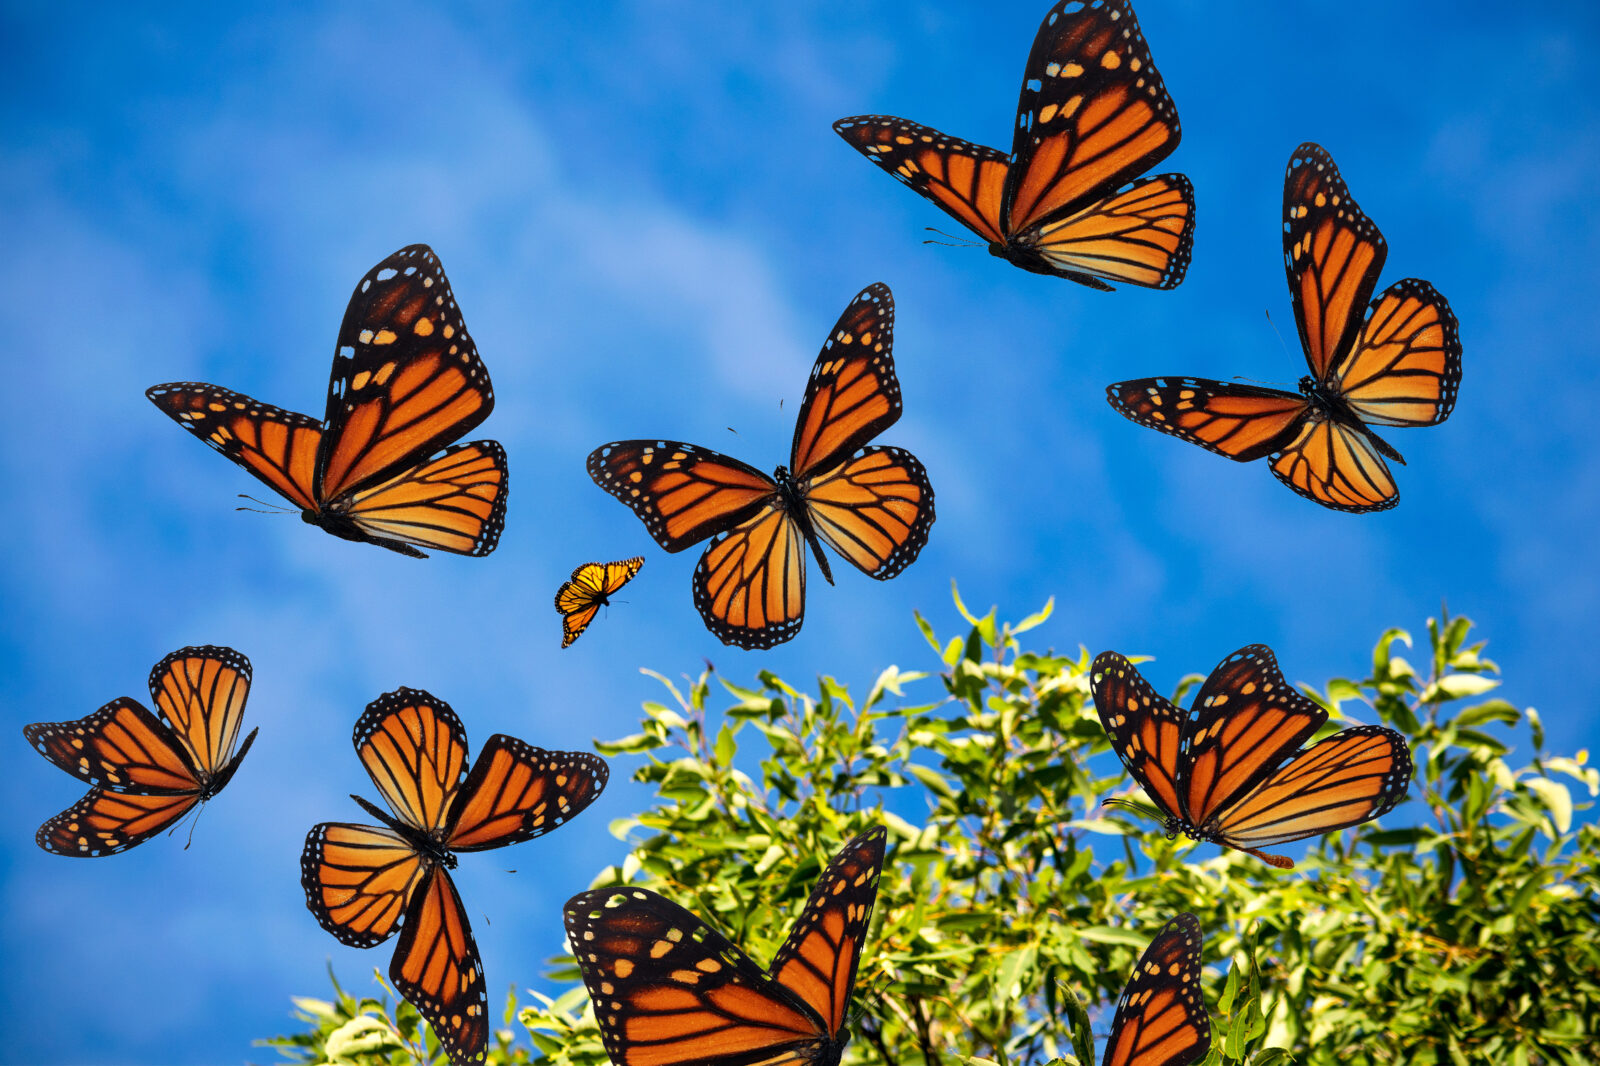

*Image source: Relevant Magazine*

# 🦋 Butterfly Classification

Inspiration for the code was taken from this [awesome bird classification notebook](https://www.kaggle.com/code/vencerlanz09/bird-classification-using-cnn-efficientnetb0) and [this guide to TPUs for flower classification](https://www.kaggle.com/code/philculliton/a-simple-petals-tf-2-2-notebook/notebook).

In this notebook, we will be employing TPUs and using a CNN with Google's EfficientNet V2 model to classify the butterflies in the dataset.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.layers import Dense, Dropout, Conv2D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm

# Detect Current Accelerator

For this notebook, we will be employing TPUs to speed up the training process.

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    print("No TPUs detected")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Load Data

In [ ]:
INPUT_DIR = "../input/butterfly-image-classification"
TRAIN_DIR = f"{INPUT_DIR}/train"
TEST_DIR = f"{INPUT_DIR}/test"

# we will only use the training set provided, split this into a training and validation
# set, and use these to train our model
meta_df = pd.read_csv(os.path.join(INPUT_DIR, "Training_set.csv"))
meta_df.head()

In [ ]:
meta_df.shape

## Data Pre-Processing

We see that our metadata `meta_df` contains the filenames and corresponding labels for the training set images. 

Firstly, we need to extract the images from the training set and combine them into the labels to make a dataset.

We also need to convert the labels into one-hot encodings, so that we can use these in our model later on.

In [ ]:
images = []
labels = []
label_encodings = []

label_encoder = LabelEncoder()
meta_df["label_encoding"] = label_encoder.fit_transform(meta_df["label"])
pbar = tqdm(list(meta_df.iterrows()))

for index, entry in pbar: 
    image = np.asarray(Image.open(os.path.join(TRAIN_DIR, entry["filename"])))
    label = entry["label"]
    label_encoding = entry["label_encoding"]
    
    images.append(image)
    labels.append(label)
    label_encodings.append(label_encoding)

Let's see the shape of one of the images in our dataset:

In [ ]:
images[0].shape

Similarly, let's see how our label and label encodings look like:

In [ ]:
labels[0:10]

In [ ]:
label_encodings[0:10]

## Visualizing Data

Let's examine some random images from this dataset, alongside the corresponding labels.

In [ ]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
plt.subplots_adjust(top=1.0)

for idx, ax in enumerate(axes.flat):
    image = images[idx]
    label_name = labels[idx]
    
    ax.imshow(image)
    ax.set(title=label_name)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Distribution of Labels

We can also check the distribution of labels in our dataset.

In [ ]:
plt.figure(figsize=(12, 8))
meta_df["label"].value_counts().plot(kind="bar")
# sns.countplot(data=meta_df, x-)
plt.show()

# Modelling

We will be using a neural network with Efficient Net V2 to classify the different butterfly categories.

In [ ]:
with strategy.scope():
    efficient_net = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",
                   trainable=False)
    
    model = keras.Sequential([
        efficient_net,
#         keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(75, activation='softmax'),
    ])
    
    model.build([None, 224, 224, 3])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

Let's display a summary of our model so far:

In [ ]:
model.summary()

## Training the Model

We will now compile and train the model. We first need to convert our images and labels into Numpy arrays, and then split our images and labels into a training and test set:

In [ ]:
np_images = np.asarray(images).astype('float64') / 255
np_label_encodings = np.asarray(label_encodings).astype('float64')
print(f"Shape of images: {np_images.shape}")
print(f"Shape of label encodings: {np_label_encodings.shape}")

In [ ]:
images_train, images_test, label_encodings_train, label_encodings_test = train_test_split(np_images, np_label_encodings, train_size=0.7)
print(f"Shape of training images: {images_train.shape}")
print(f"Shape of training label encodings: {label_encodings_train.shape}")
print(f"Shape of validation images: {images_test.shape}")
print(f"Shape of validation label encodings: {label_encodings_test.shape}")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, label_encodings_train)).repeat().shuffle(10000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, label_encodings_test)).batch(1)

In [ ]:
EPOCHS = 5
STEPS_PER_EPOCH = 2000
VALIDATION_STEPS = 1000

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_dataset)

# Visualizing Model Accuracy

We can visualize how well our model performs on the validation set by mapping the predictions to the images in the validation set, and checking whether they match the actual labels.

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25,25))

sample_test_dataset = test_dataset.take(25)
sample_test_dataset_np = [(image, label_encoding) for (image, label_encoding) in sample_test_dataset]
predictions = model.predict(sample_test_dataset).argmax(axis=1)

for ax, (image, act_label_encoding), pred_label_encoding in zip(axes.flat, sample_test_dataset, predictions):
    actual_label_encoding_np = act_label_encoding.numpy().astype(int)
    actual_label_name = label_encoder.inverse_transform(actual_label_encoding_np)[0]
    
    pred_label_encoding_np = pred_label_encoding.astype(int)
    pred_label_name = label_encoder.inverse_transform([pred_label_encoding_np])[0]
    
    ax.imshow(image.numpy().reshape(224, 224, 3))
    ax.set(title=f"Predicted: {pred_label_name}\nActual: {actual_label_name}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

# Evaluating Model

## Precision, Accuracy, Recall, F1

We can evaluate our trained model by using the following metrics:

In [ ]:
test_predictions = model.predict(test_dataset).argmax(axis=1).astype(int)
test_actual = [label_encoding.numpy()[0].astype(int) for (image, label_encoding) in test_dataset]

In [ ]:
print(f"Accuracy: {accuracy_score(test_predictions, test_actual)}")
print(f"Precision: {precision_score(test_predictions, test_actual, average='macro')}")
print(f"Recall: {recall_score(test_predictions, test_actual, average='macro')}")
print(f"F1 score: {f1_score(test_predictions, test_actual, average='macro')}")

## Confusion Matrix

We can also plot the confusion matrix for our model.

In [ ]:
confusion_matrix = tf.math.confusion_matrix(test_actual, test_predictions)
plt.imshow(confusion_matrix)
plt.show()

## Thank you for reading! :)

## 